In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [2]:

sig_c = 0.05      # bipolar receptive fied size ~ 1/5 of the actual size [mm]
tau1 = 0.04       # excitation time constant of the remporal filter [s]
tau2 = 0.0876     # rebound time constant [s]
bifw = 0.         # relative weight of rebound/excitation [1]
# scale_mV = 1.     # UPDATED 
scale_mV = 20.     # UPDATED 

tauA = 0.15   # time constant of amacrine cells [s]
tauB = 0.08   # time constant of bipolar cells [s]
tauG = 0.01   # time contant of ganglion cells [s]

wAB = 10.     # synaptic weight from bipolar to amacrine [Hz]
wBA = -10.    # synaptic weight from amacrine to bipolar [Hz]
wGB = 4.0     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
wGA = 0.      # synaptic weight from amacrine  to gangion  [Hz]

slope = 5  # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
threshold = 0 # threshold for ganglion cell recritifation [Hz/mV]

sig_pool = 0.065   # sigma for gaussian pooling in ganlion gells [mm]
spacing = 0.005    # spacing of cells on the lattice [mm]

N = 300             # number of neurons in each layer [1]
idx = int(N/2)

b =  0.160          # half bar width [mm]
speed =  0.8        # speed [mm/s]
dt = 0.001          # integration time step [s]


In [3]:

# function to make bar stimulus
def bar(t, x, b, v):

    if x >=-b+v*t and x <=b+v*t :
        return 1
    else:
        return 0


# function that defines the temporal kernel
def biphasic_alpha(t,tau1,tau2,bifw):

    kern =  (t/(tau1**2)) * np.exp(-t/tau1) * np.heaviside(t,1) -  bifw* (t/(tau2**2)) * np.exp(-t/tau2) * np.heaviside(t,1)
    return  kern


# function for gaussialn pooling
def DOG(x, mu, sig_c):

    kern =  np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig_c, 2.)))
    kern = kern / kern.max() # normalize
    return kern


# function to simulate OPL inputs as spatiotemporal convolution
def OPL(stim):

    N,tps = stim.shape
    spat = np.zeros((N,tps))
    temp = np.zeros((N,tps))

    spat = gaussian_filter1d(stim, sig_c/spacing, axis = 0)
    #spat = gaussian_filter1d(stim, sig_c/dt, axis = 1)
    spat = spat/np.max(spat)

    for n in range(N):
        spat[n,:] = spat[n,:]/np.max(spat[n,:])
        # apply temporal filter
        temp[n,:] = convolve(spat[n,:],temporal_kernel, mode = 'full')[:-len(temporal_kernel)+1]*dt*scale_mV



    return spat,temp


# function to transpofm OPL voltage response into input current (divided by capacitance) for bipolars
def F(temp):

        N,tps = temp.shape
        F_array = np.zeros((N,tps))

        for c in range(N):
            outst =  np.zeros(tps)
            outst[:] = temp[c,:].copy()
            outst_prime = [(outst[i]-outst[i-1])/dt for i in range(0,tps)]
            F_array[c,:] = outst[:]/tauB + outst_prime

        return F_array




In [4]:
# define equations for bipolar and amacrine cell

#equation that defines the BC voltage, with input
eqs_bc = """ dv/dt = -(1/tau) * v + vsyn + inp(t,i): volt

tau : second
vsyn : volt/second
"""


#equation that defines the AC voltage
eqs_ac = """ dv/dt = -(1/tau) * v + vsyn : volt

tau : second
vsyn : volt/second
"""


# equation for synaptic coupling
eqs_syn = """vsyn_post = wsyn*v_pre : volt/second (summed)

wsyn: Hz

"""


# equation that defines GC integration
eqs_gc = """ dv/dt = -(1/tau) * v + vsyn : volt

tau : second
vsyn : volt/second
"""



In [ ]:
def simulate(input_matrix):

    start_scope()                # start the stimulation environment
    defaultclock.dt = dt*second  # set integration time step

    N,tps = input_matrix.shape   # extract some parameter
    dur = tps*dt                 # duration of the siulation [s]


    # create neurons
    bc = NeuronGroup(N, eqs_bc,  method = 'euler')
    ac = NeuronGroup(N, eqs_ac,  method = 'euler')
    gc = NeuronGroup(N,eqs_gc,method = 'euler')

    # create synapses
    synab = Synapses(bc,ac,eqs_syn)       # create synapse form BC to AC
    synba = Synapses(ac,bc,eqs_syn)       # create synapse form AC to BC


    # create connectivity matrix
    C = np.zeros((N,N))
    ii = np.arange(0,N-1,1).astype(int)  # list of source cells for rightward connections
    ji = ii+1                            # target cells of rightward connections


    C[ii,ji] = 1

    ii = np.arange(1,N,1).astype(int)    # list of source cells for leftward connections
    ji = ii-1                            # target cells of leftward connections

    C[ii,ji] = 1

    sources, targets = C.nonzero()      # get cell indices for sources and targets
    synab.connect(i=sources, j=targets) # connect sources and targets BC to AC
    synba.connect(i=sources, j=targets) # connect sources and targets AC to BC


    syngb = Synapses(bc,gc,eqs_syn)     # create synapses BC to GC
    syngb.connect()                     # connect all to all


    # set parameter
    bc.tau = tauB * second
    synba.wsyn = wBA * Hz


    ac.tau = tauA * second
    synab.wsyn = wAB * Hz

    gc.tau = tauG * second

    # assign gaussian weighting to synapses from BC to GC
    for n in range(N):
        syngb.wsyn[n,:] = wGB* DOG(np.arange(N),n,sig_pool/spacing)*Hz


    # info: there are no forward connections from AC to GC here, they could be added similar to syngb

    # transform input as timed array for integration
    inp = TimedArray(input_matrix.T*scale_mV*mV/second,dt=defaultclock.dt)

    # set up monitors to record cell voltages
    monbc = StateMonitor(bc, ('v'), record = True)
    monac = StateMonitor(ac, ('v'), record = True)
    mongc = StateMonitor(gc, ('v'), record = True)
    run(dur*second)


    # todo: pass GC voltage thorugh nonlinearity for firing rate transformation

    # todo: save output automatically ?


    return [monbc.v[int(N/2)]/mV, monac.v[int(N/2)]/mV, mongc.v[int(N/2)]/mV]   # info: here you can change the output to return the voltage of all cells


# function to set a different speed for the moving bar
def choose_speed(speed):

    # recalculate some params
    dur = L/speed
    tps = int(dur/dt)
    time = np.arange(0,tps)*dt

    # make stimulus
    barstim = np.zeros((N,tps))

    for n in range(N):
        for ti in range(tps):
            x = n*spacing
            barstim[n,ti] = bar(ti*dt,x,b,speed)


    # simulate OPL
    spat,temp = OPL(barstim)

    #simulate network
    res = simulate(temp)

    return [time,barstim[idx,:],spat[idx,:],temp[idx,:],res]



# info: you could write a similar function to set the number of cells as choose_speed


In [6]:
# make temporal kernel
ftime = np.arange(0,1,dt)
temporal_kernel = biphasic_alpha(ftime,tau1,tau2,bifw)



# impulse response simulation

In [8]:
# params to calculate
x = idx*spacing               # cell position [mm]
L = N*spacing                 # length of the simulated area [mm]
dur = 3.                      # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]
time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# initialize the stimulus
impmat = np.zeros((N,tps))
impmat[:,int(tps/2)] = 1

# simulate OPL response and input to bipolars
spat,temp = OPL(impmat)
Ftemp = F(temp)

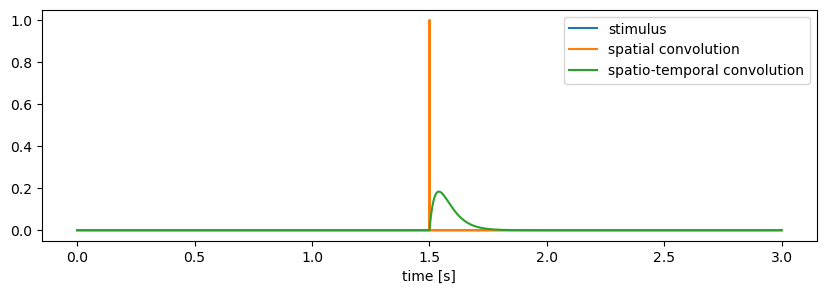

In [9]:
# plot OPL processing steps
fig = plt.figure(figsize = (10,3))
plt.plot(time,impmat[int(N/2),:], label = 'stimulus')
plt.plot(time,spat[int(N/2),:], label = 'spatial convolution')
plt.plot(time,temp[int(N/2),:], label = 'spatio-temporal convolution') #todo: rescale temporal convolution for visualization ?
# plt.plot(time,Ftemp[int(N/2),:], label = 'F')
plt.xlabel('time [s]')
plt.legend()

In [10]:
# simulate the network
res = simulate(Ftemp)

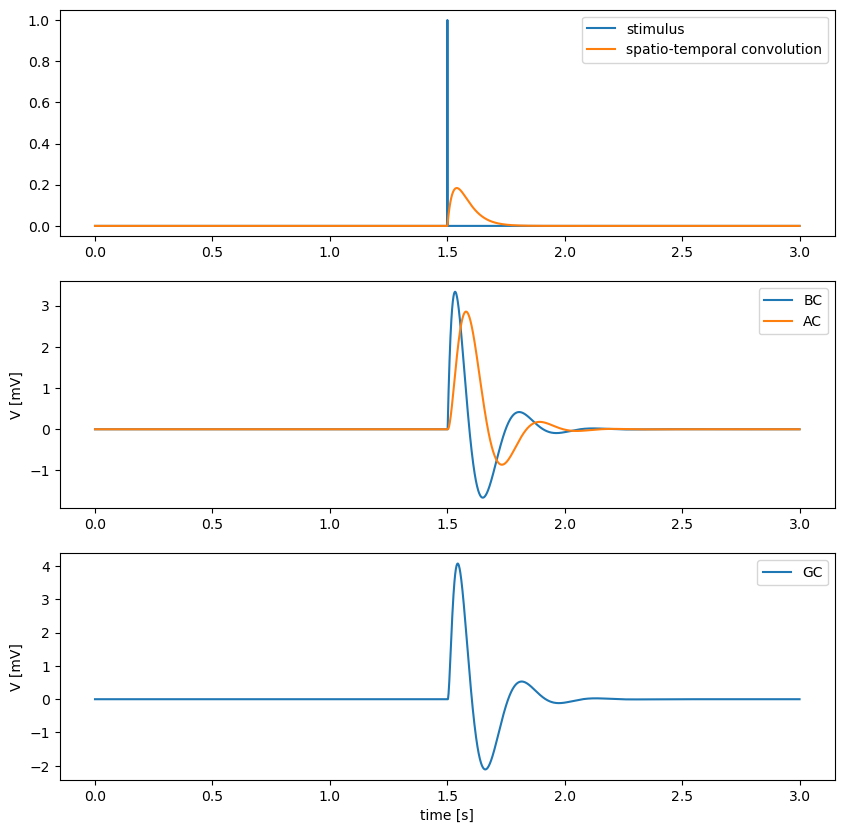

In [11]:
# visualize the network response
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)

ax = fig.add_subplot(gs[0,0])
plt.plot(time,impmat[int(N/2),:], label = 'stimulus')
plt.plot(time,temp[int(N/2),:], label = 'spatio-temporal convolution')
plt.legend()

ax = fig.add_subplot(gs[1,0])
plt.plot(time,res[0], label = 'BC')
plt.plot(time,res[1], label = 'AC')
plt.ylabel('V [mV]')
plt.legend()

ax = fig.add_subplot(gs[2,0])
plt.plot(time,res[2], label = 'GC')
plt.xlabel('time [s]')
plt.ylabel('V [mV]')
plt.legend()

## 2D visualization of the systen (to be completed)

Text(0, 0.5, 'N')

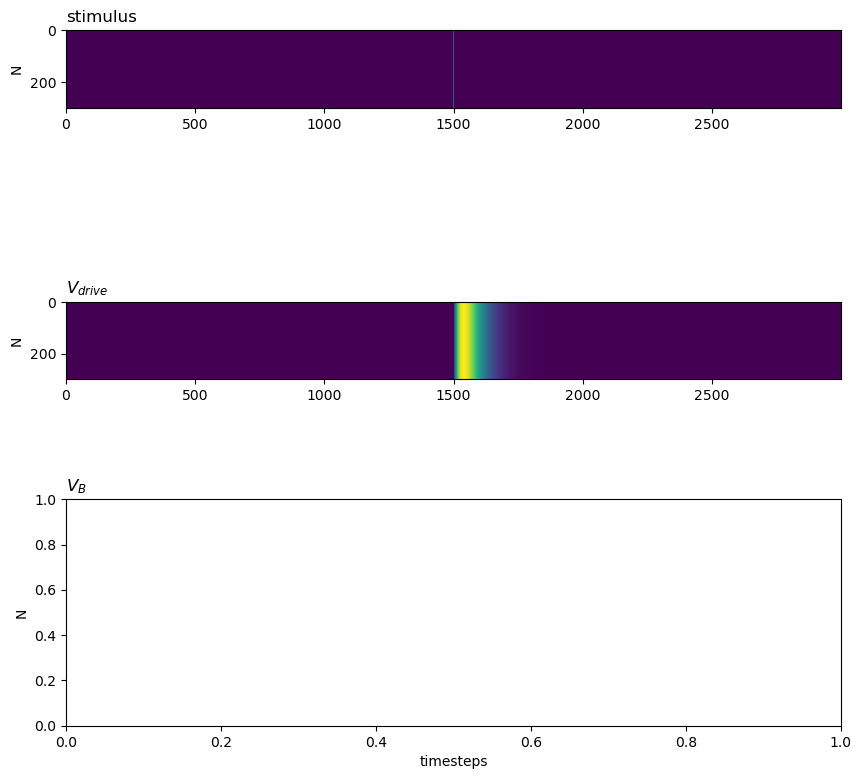

In [13]:

fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)


# stimulus
ax = fig.add_subplot(gs[0,0])
ax.set_title('stimulus', loc = 'left')
plt.imshow(impmat)
plt.ylabel('N')


ax = fig.add_subplot(gs[1,0])
ax.set_title('$V_{drive}$', loc = 'left')
plt.imshow(temp)
plt.ylabel('N')

ax = fig.add_subplot(gs[2,0])
ax.set_title('$V_{B}$', loc = 'left')
# to be completed
plt.xlabel('timesteps')
plt.ylabel('N')


# moving bar simulation example speed 0.8 mm/s

In [15]:
# params to calculate
x = idx*spacing               # cell position [mm]
L = N*spacing                 # length of the simulated area [mm]
dur = L/speed                 # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]
time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# make bar stimulus
barstim = np.zeros((N,tps))

for n in range(N):
    for ti in range(tps):
        xi = n*spacing
        barstim[n,ti] = bar(ti*dt,xi,b,speed)


# simulate OPL response and input to bipolars
spat,temp = OPL(barstim)
Ftemp = F(temp)

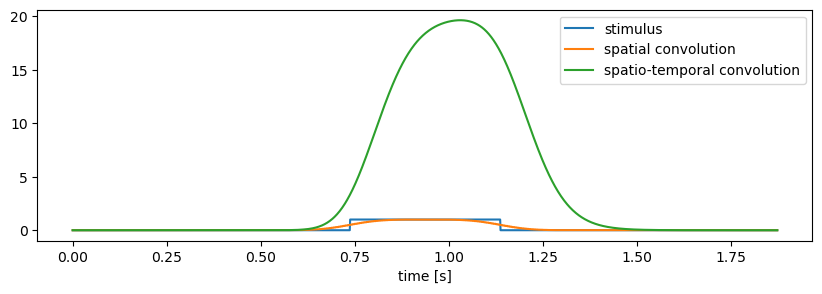

In [16]:
# visualize OPL steps
fig = plt.figure(figsize = (10,3))
plt.plot(time,barstim[int(N/2),:], label = 'stimulus')
plt.plot(time,spat[int(N/2),:], label = 'spatial convolution')
plt.plot(time,temp[int(N/2),:], label = 'spatio-temporal convolution')
# plt.plot(time,Ftemp[int(N/2),:], label = 'F')
plt.xlabel('time [s]')
plt.legend()

In [17]:
#  simulate network
res = simulate(temp)

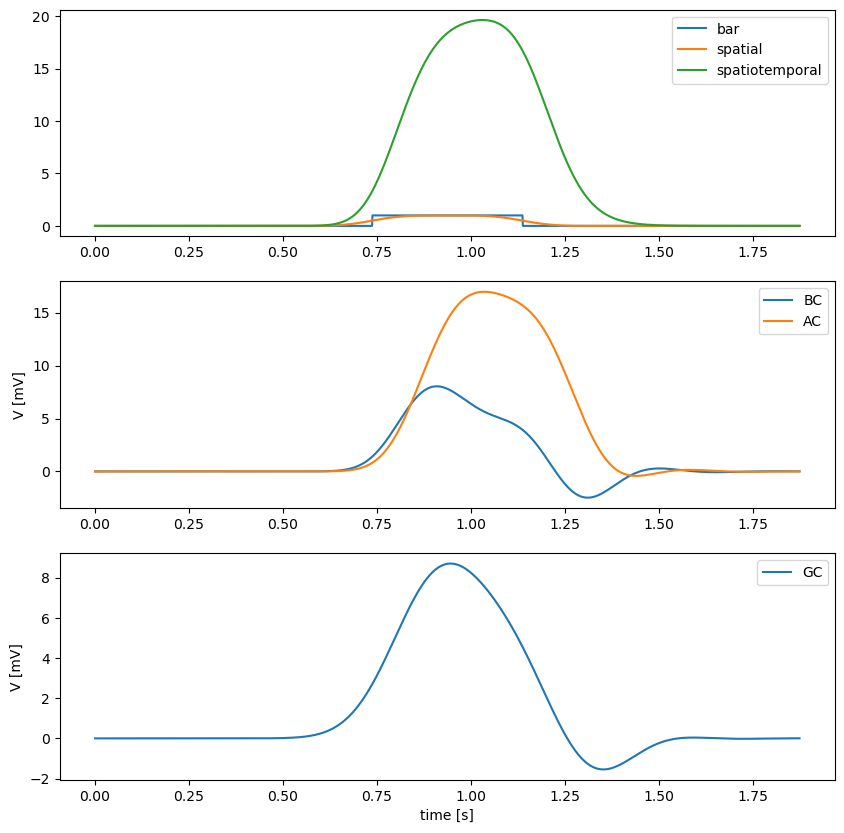

In [18]:
# visualize network response
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)

ax = fig.add_subplot(gs[0,0])
plt.plot(time,barstim[int(N/2),:], label = 'bar')
plt.plot(time,spat[int(N/2),:], label = 'spatial')
plt.plot(time,temp[int(N/2),:], label = 'spatiotemporal')
plt.legend()

ax = fig.add_subplot(gs[1,0])
plt.plot(time,res[0], label = 'BC')
plt.plot(time,res[1], label = 'AC')
plt.ylabel('V [mV]')
plt.legend()

ax = fig.add_subplot(gs[2,0])
plt.plot(time,res[2], label = 'GC')

plt.ylabel('V [mV]')
plt.xlabel('time [s]')

plt.legend()


# simuate responses to different speeds

In [ ]:
# define speed range to loop over
speeds = np.arange(0.1,5.1,0.1)

# simulate with differnt speeds in parallel
num_cores = 4
with multiprocessing.Pool(processes = num_cores) as p:
    results = p.map(choose_speed, speeds)

## in time

In [ ]:
fig = plt.figure(figsize = (15,15))
fig.suptitle('temporal responses at each stage of the model')

gs = fig.add_gridspec(6,1)
fig.subplots_adjust(hspace = .5)


axbar = fig.add_subplot(gs[0,0])
axspat = fig.add_subplot(gs[1,0])
axtemp = fig.add_subplot(gs[2,0])
axbc = fig.add_subplot(gs[3,0])
axac = fig.add_subplot(gs[4,0])
axgc = fig.add_subplot(gs[5,0])


axbar.set_title('stimulus', loc = 'left')
axspat.set_title('spatial convolution', loc = 'left')
axtemp.set_title('spatio-temporal convolution', loc = 'left')
axbc.set_title('BC', loc = 'left')
axac.set_title('AC', loc = 'left')
axgc.set_title('GC', loc = 'left')


shift_temp = []
shift_bc = []
shift_ac = []
shift_gc = []


t_bars = []
t_temp = []
t_bc = []
t_ac = []
t_gc = []


max_bars = []
max_temp = []
max_bc = []
max_ac = []
max_gc = []



for si,s in enumerate(speeds):

    space = results[si][0]*s
    time = results[si][0]

    ba = results[si][1]
    spa = results[si][2]
    tem = results[si][3]
    bcr = results[si][4][0]
    acr = results[si][4][1]
    gcr = results[si][4][2]


    # calculate peak shift
    t_bar = x/s


    axbar.plot(time-t_bar,ba, label = f'{np.round(s,1)} [mm/s]')
    axspat.plot(time-t_bar,spa)
    axtemp.plot(time-t_bar,tem)
    axbc.plot(time-t_bar,bcr)
    axac.plot(time-t_bar,acr)
    axgc.plot(time-t_bar,gcr)



    axbar.axvline(0, linestyle = ':', color = 'k')
    axspat.axvline(0, linestyle =  ':', color = 'k')
    axtemp.axvline(0, linestyle =  ':', color = 'k')
    axbc.axvline(0, linestyle =  ':', color = 'k')
    axac.axvline(0, linestyle =  ':', color = 'k')
    axgc.axvline(0, linestyle = ':', color = 'k')



#     axtemp.scatter(time[np.argmax(tem)]-t_bar, np.max(tem), zorder = 10)
#     axbc.scatter(time[np.argmax(bcr)]-t_bar, np.max(bcr), zorder = 10)
#     axac.scatter(time[np.argmax(acr)]-t_bar, np.max(acr), zorder = 10)
#     axgc.scatter(time[np.argmax(gcr)]-t_bar, np.max(gcr), zorder = 10)


    shift_temp.append(t_bar - time[np.argmax(tem)])
    shift_bc.append(t_bar - time[np.argmax(bcr)])
    shift_ac.append(t_bar - time[np.argmax(acr)])
    shift_gc.append(t_bar - time[np.argmax(gcr)])#

    t_bars.append(t_bar)
    t_temp.append(time[np.argmax(tem)])
    t_bc.append(time[np.argmax(bcr)])
    t_ac.append(time[np.argmax(acr)])
    t_gc.append(time[np.argmax(gcr)])


    max_bars.append(np.max(ba))
    max_temp.append(np.max(tem))
    max_bc.append(np.max(bcr))
    max_ac.append(np.max(acr))
    max_gc.append(np.max(gcr))


    fig.legend()
    axgc.set_xlabel('time to bar center over RF center [s]')

    axtemp.set_ylabel('V [mV]')
    axbc.set_ylabel('V [mV]')
    axac.set_ylabel('V [mV]')
    axgc.set_ylabel('V [mV]')




In [ ]:

fig = plt.figure(figsize = (15,10))
fig.suptitle('temporal peak and shift for different speeds')

gs = fig.add_gridspec(2,5)
fig.subplots_adjust(wspace = .5)


axbar  = fig.add_subplot(gs[0,0])
axtemp = fig.add_subplot(gs[0,1])
axbc = fig.add_subplot(gs[0,2])
axac = fig.add_subplot(gs[0,3])
axgc = fig.add_subplot(gs[0,4])


axbar.set_title('peak bar')
axtemp.set_title('peak drive')
axbc.set_title('peak BC')
axac.set_title('peak AC')
axgc.set_title('peak GC')



axtemp.set_xlabel('speed [mm/s]')
axbc.set_xlabel('speed [mm/s]')
axac.set_xlabel('speed [mm/s]')
axgc.set_xlabel('speed [mm/s]')

axbar.set_ylabel('$t_{bar} [s]$')
axtemp.set_ylabel('$t_{peak} [s]$')


axbar.scatter(speeds,t_bars)
axtemp.scatter(speeds,t_temp)
axbc.scatter(speeds,t_bc)
axac.scatter(speeds,t_ac)
axgc.scatter(speeds,t_gc)


axtemp = fig.add_subplot(gs[1,1])
axbc = fig.add_subplot(gs[1,2])
axac = fig.add_subplot(gs[1,3])
axgc = fig.add_subplot(gs[1,4])


axtemp.set_title('shift drive')
axbc.set_title('shift BC')
axac.set_title('shift AC')
axgc.set_title('shift GC')


axbar.set_xlabel('speed [mm/s]')
axtemp.set_xlabel('speed [mm/s]')
axbc.set_xlabel('speed [mm/s]')
axac.set_xlabel('speed [mm/s]')
axgc.set_xlabel('speed [mm/s]')

axtemp.set_ylabel(r'$\delta t =  t_{bar} - t_{peak} [s]$')

axtemp.scatter(speeds,shift_temp)
axbc.scatter(speeds,shift_bc)
axac.scatter(speeds,shift_ac)
axgc.scatter(speeds,shift_gc)


## in space

In [ ]:
fig = plt.figure(figsize = (15,15))
fig.suptitle('spatial responses at each stage of the model')

gs = fig.add_gridspec(6,1)
fig.subplots_adjust(hspace = .5)


axbar = fig.add_subplot(gs[0,0])
axspat = fig.add_subplot(gs[1,0])
axtemp = fig.add_subplot(gs[2,0])
axbc = fig.add_subplot(gs[3,0])
axac = fig.add_subplot(gs[4,0])
axgc = fig.add_subplot(gs[5,0])


axbar.set_title('stimulus', loc = 'left')
axspat.set_title('spatial convolution', loc = 'left')
axtemp.set_title('spatio-temporal convolution', loc = 'left')
axbc.set_title('BC', loc = 'left')
axac.set_title('AC', loc = 'left')
axgc.set_title('GC', loc = 'left')

shift_temp = []
shift_bc = []
shift_ac = []
shift_gc = []


t_bars = []
t_temp = []
t_bc = []
t_ac = []
t_gc = []

for si,s in enumerate(speeds):

    space = results[si][0]*s - x
    time = results[si][0]
    ba = results[si][1]
    spa = results[si][2]
    tem = results[si][3]
    bcr = results[si][4][0]
    acr = results[si][4][1]
    gcr = results[si][4][2]



    # calculate peak shift
    t_bar = x/s


    axbar.plot(space,ba, label = f'{np.round(s,1)} [mm/s]')
    axspat.plot(space,spa)
    axtemp.plot(space,tem)
    axbc.plot(space,bcr)
    axac.plot(space,acr)
    axgc.plot(space,gcr)


    axbar.axvline(0, linestyle = ':', color = 'k')
    axspat.axvline(0, linestyle =  ':', color = 'k')
    axtemp.axvline(0, linestyle =  ':', color = 'k')
    axbc.axvline(0, linestyle =  ':', color = 'k')
    axac.axvline(0, linestyle =  ':', color = 'k')
    axgc.axvline(0, linestyle = ':', color = 'k')


    axtemp.scatter(space[np.argmax(tem)], np.max(tem), zorder = 10)
    axbc.scatter(space[np.argmax(bcr)], np.max(bcr), zorder = 10)
    axac.scatter(space[np.argmax(acr)], np.max(acr), zorder = 10)
    axgc.scatter(space[np.argmax(gcr)], np.max(gcr), zorder = 10)


    shift_temp.append(t_bar - time[np.argmax(tem)])
    shift_bc.append(t_bar - time[np.argmax(bcr)])
    shift_ac.append(t_bar - time[np.argmax(acr)])
    shift_gc.append(t_bar - time[np.argmax(gcr)])#

    t_bars.append(t_bar)
    t_temp.append(time[np.argmax(tem)])
    t_bc.append(time[np.argmax(bcr)])
    t_ac.append(time[np.argmax(acr)])
    t_gc.append(time[np.argmax(gcr)])


fig.legend()

axgc.set_xlabel('distance to receptive field center [mm]')
axtemp.set_ylabel('V [mV]')
axbc.set_ylabel('V [mV]')
axac.set_ylabel('V [mV]')
axgc.set_ylabel('V [mV]')

In [ ]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('spatial peak and shift for different speeds')
gs = fig.add_gridspec(2,4)


axtemp = fig.add_subplot(gs[0,0])
axbc = fig.add_subplot(gs[0,1])
axac = fig.add_subplot(gs[0,2])
axgc = fig.add_subplot(gs[0,3])


axtemp.set_title('peak drive')
axbc.set_title('peak BC')
axac.set_title('peak AC')
axgc.set_title('peak GC')


axtemp.set_xlabel('speed [mm/s]')
axbc.set_xlabel('speed [mm/s]')
axac.set_xlabel('speed [mm/s]')
axgc.set_xlabel('speed [mm/s]')


axtemp.set_ylabel('$x_{peak}$ [mm]')


axtemp.scatter(speeds,t_temp*speeds)
axbc.scatter(speeds,t_bc*speeds)
axac.scatter(speeds,t_ac*speeds)
axgc.scatter(speeds,t_gc*speeds)


axtemp = fig.add_subplot(gs[1,0])
axbc = fig.add_subplot(gs[1,1])
axac = fig.add_subplot(gs[1,2])
axgc = fig.add_subplot(gs[1,3])


axtemp.set_title('shift drive')
axbc.set_title('shift BC')
axac.set_title('shift AC')
axgc.set_title('shift GC')

axtemp.set_xlabel('speed [mm/s]')
axbc.set_xlabel('speed [mm/s]')
axac.set_xlabel('speed [mm/s]')
axgc.set_xlabel('speed [mm/s]')

axtemp.set_ylabel(r'$\delta x =  x_{bar} - x_{peak} [mm]$')

axtemp.scatter(speeds,shift_temp*speeds)
axbc.scatter(speeds,shift_bc*speeds)
axac.scatter(speeds,shift_ac*speeds)
axgc.scatter(speeds,shift_gc*speeds)


## amplitudes

In [ ]:

fig = plt.figure(figsize = (15,5))
fig.suptitle('max amplitude for different speeds')

gs = fig.add_gridspec(1,5)
fig.subplots_adjust(wspace = .5)


axbar  = fig.add_subplot(gs[0,0])
axtemp = fig.add_subplot(gs[0,1])
axbc = fig.add_subplot(gs[0,2])
axac = fig.add_subplot(gs[0,3])
axgc = fig.add_subplot(gs[0,4])


axbar.set_title('peak bar')
axtemp.set_title('peak drive')
axbc.set_title('peak BC')
axac.set_title('peak AC')
axgc.set_title('peak GC')



axtemp.set_xlabel('speed [mm/s]')
axbc.set_xlabel('speed [mm/s]')
axac.set_xlabel('speed [mm/s]')
axgc.set_xlabel('speed [mm/s]')

axbar.set_ylabel('$V_{bar}^{max} [s]$')
axtemp.set_ylabel('$V_{peak}^{max} [s]$')


axbar.scatter(speeds,max_bars)
axtemp.scatter(speeds,max_temp)
axbc.scatter(speeds,max_bc)
axac.scatter(speeds,max_ac)
axgc.scatter(speeds,max_gc)
